<a href="https://colab.research.google.com/github/Deepikadandolu/Internship/blob/main/rawithbitbraindata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1: SETUP

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


Mounted at /content/drive


In [2]:
# 2: LOAD DATA

excel_df = pd.read_excel('/content/drive/MyDrive/837.xlsx')
excel_df.to_csv('837.csv', index=False)

print("Excel converted to CSV")
display(excel_df.head())


Excel converted to CSV


,Timestamp [ms],CPU capacity provisioned [MHZ],CPU usage [%],Unnamed: 3,Disk read throughput [KB/s];,Disk write throughput [KB/s];,Network received throughput [KB/s];,Network transmitted throughput [KB/s]
0,1376314846,2925.99923,0.0,6290.4;,0.0;,0.0;,0.0;,0
1,1376315146,2925.99923,0.0,0.0;,0.0;,0.0;,0.0;,0
2,1376315446,2925.99923,0.0,9086.133333333333;,0.0;,0.0;,0.0;,0
3,1376315746,2925.99923,0.0,2096.8;,0.0;,0.0;,0.0;,0
4,1376316046,2925.99923,0.0,20269.866666666665;,0.0;,0.0;,0.0;,0


In [3]:
# 3.

df = pd.read_csv('837.csv')

# Clean column names aggressively
df.columns = (
    df.columns
    .str.strip()
    .str.replace('\t', '', regex=True)
    .str.replace('\n', '', regex=True)
)

print("Available columns in dataset:\n")
for c in df.columns:
    print("-", c)

# ---- Auto-detect required columns ----
cpu_col = [c for c in df.columns if 'cpu usage' in c.lower()][0]
cap_col = [c for c in df.columns if 'capacity' in c.lower()][0]
net_rx  = [c for c in df.columns if 'received' in c.lower()][0]
net_tx  = [c for c in df.columns if 'transmitted' in c.lower()][0]

print("\nSelected columns:")
print("CPU usage        :", cpu_col)
print("CPU capacity     :", cap_col)
print("Network RX       :", net_rx)
print("Network TX       :", net_tx)

# Select and clean data
df = df[[cpu_col, cap_col, net_rx, net_tx]].dropna().reset_index(drop=True)

display(df.head())
print("Dataset shape:", df.shape)



Available columns in dataset:

- Timestamp [ms]
- CPU capacity provisioned [MHZ]
- CPU usage [%]
- Unnamed: 3
- Disk read throughput [KB/s];
- Disk write throughput [KB/s];
- Network received throughput [KB/s];
- Network transmitted throughput [KB/s]

Selected columns:
CPU usage        : CPU usage [%]
CPU capacity     : CPU capacity provisioned [MHZ]
Network RX       : Network received throughput [KB/s];
Network TX       : Network transmitted throughput [KB/s]


,CPU usage [%],CPU capacity provisioned [MHZ],Network received throughput [KB/s];,Network transmitted throughput [KB/s]
0,0.0,2925.99923,0.0;,0
1,0.0,2925.99923,0.0;,0
2,0.0,2925.99923,0.0;,0
3,0.0,2925.99923,0.0;,0
4,0.0,2925.99923,0.0;,0


Dataset shape: (8636, 4)


In [4]:
#4: CLEAN NUMERIC DATA + NORMALIZE

for col in df.columns:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(';', '', regex=False)
        .str.strip()
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with non-numeric values
df = df.dropna().reset_index(drop=True)

print("After numeric cleaning:")
display(df.head())
print("Dataset shape:", df.shape)

# Normalize

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns
)

display(df_scaled.head())



After numeric cleaning:


,CPU usage [%],CPU capacity provisioned [MHZ],Network received throughput [KB/s];,Network transmitted throughput [KB/s]
0,0.0,2925.99923,0.0,0
1,0.0,2925.99923,0.0,0
2,0.0,2925.99923,0.0,0
3,0.0,2925.99923,0.0,0
4,0.0,2925.99923,0.0,0


Dataset shape: (8636, 4)


,CPU usage [%],CPU capacity provisioned [MHZ],Network received throughput [KB/s];,Network transmitted throughput [KB/s]
0,0.0,0.247466,0.0,0.0
1,0.0,0.247466,0.0,0.0
2,0.0,0.247466,0.0,0.0
3,0.0,0.247466,0.0,0.0
4,0.0,0.247466,0.0,0.0


In [6]:
#5: SEQUENCE CREATION

cpu_col = [c for c in df_scaled.columns if 'cpu' in c.lower() and 'usage' in c.lower()][0]

print("Using CPU column for workload:", cpu_col)

cpu = df_scaled[cpu_col].values

X, y = [], []
for i in range(len(cpu) - 1):
    X.append([cpu[i]])
    y.append(cpu[i + 1])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Sample X:", X[:5].flatten())
print("Sample y:", y[:5])



Using CPU column for workload: CPU usage [%]
X shape: (8635, 1)
y shape: (8635,)
Sample X: [0. 0. 0. 0. 0.]
Sample y: [0. 0. 0. 0. 0.]


In [7]:
# CELL 6: AUTOENCODER

inp = Input(shape=(1,))
e1 = Dense(16, activation='relu')(inp)
e2 = Dense(8, activation='relu')(e1)
latent = Dense(4, activation='relu')(e2)
d1 = Dense(8, activation='relu')(latent)
d2 = Dense(16, activation='relu')(d1)
out = Dense(1)(d2)

autoencoder = Model(inp, out)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405 (1.58 KB)

 Trainable params: 405 (1.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 2/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 9/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 10/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 11/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 12/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

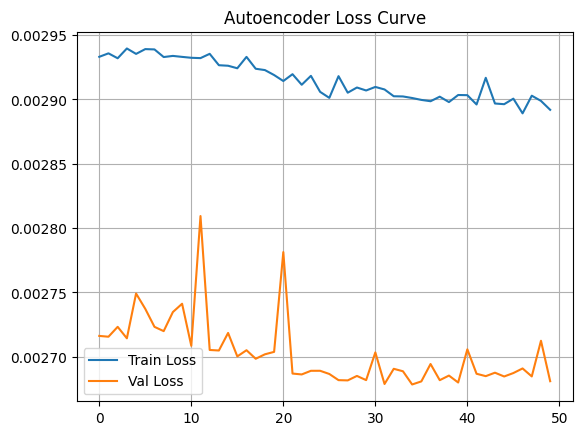

In [8]:
# CELL 7: TRAINING

history = autoencoder.fit(
    X, y,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Autoencoder Loss Curve")
plt.grid(True)
plt.show()


In [9]:
# CELL 8: PREDICTION METRICS

y_pred = autoencoder.predict(X).flatten()

mse = mean_squared_error(y, y_pred)

threshold = np.median(y)
y_true_cls = (y >= threshold).astype(int)
y_pred_cls = (y_pred >= threshold).astype(int)

accuracy = accuracy_score(y_true_cls, y_pred_cls)
f1 = f1_score(y_true_cls, y_pred_cls)

print("MSE      :", mse)
print("Accuracy :", accuracy)
print("F1-score :", f1)


270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSE      : 0.002869537183410282
Accuracy : 0.9974522292993631
F1-score : 0.9987244897959183


In [10]:
print("Unique true labels:", np.unique(y_true_cls, return_counts=True))
print("Unique pred labels:", np.unique(y_pred_cls, return_counts=True))

print("Number of mismatches:",
      np.sum(y_true_cls != y_pred_cls))


Unique true labels: (array([1]), array([8635]))
Unique pred labels: (array([0, 1]), array([  22, 8613]))
Number of mismatches: 22


In [11]:
from sklearn.metrics import r2_score
print("R2:", r2_score(y, y_pred))

print("Correlation:", np.corrcoef(y, y_pred)[0,1])


R2: 0.013344805803578774
Correlation: 0.11558547745693148


In [12]:
# 9. csa optimization

#Auto-detect columns
cpu_col = [c for c in df.columns if 'cpu' in c.lower() and 'usage' in c.lower()][0]
cap_col = [c for c in df.columns if 'capacity' in c.lower()][0]
rx_col  = [c for c in df.columns if 'received' in c.lower()][0]

print("Using columns:")
print("CPU usage    :", cpu_col)
print("CPU capacity :", cap_col)
print("Network RX   :", rx_col)

#Prepare variables
n = len(y_pred)

tau = df[cpu_col].values[:n]          # task size / workload
mu  = df[cap_col].values[:n]          # processing speed
b   = df[rx_col].values[:n] + 1e-6    # bandwidth (numerical safety)

#Simple cost function
def compute_cost(o, tau, mu, b):
    # count remote tasks
    remote_mask = (o != 0)
    N_remote = np.sum(remote_mask)
    N_remote = max(N_remote, 1)  # avoid divide by zero

    # local delay
    D_local = tau / mu

    # shared bandwidth delay
    D_remote = tau / (b / N_remote)

    # select delay
    D = np.where(o == 0, D_local, D_remote)

    # energy proxy
    E = 0.5 * D

    return np.sum(D + E)

# CSA with Bandwidth Optimization
pop_size = 20
iters = 50
B_max = 1.0          # total available bandwidth
eps = 1e-6           # numerical safety

# Offloading population
population = np.random.randint(-1, 2, size=(pop_size, n))

# Bandwidth population (random, normalized)
b_pop = np.random.rand(pop_size, n)
b_pop = b_pop / b_pop.sum(axis=1, keepdims=True) * B_max

best_cost = np.inf
best_o = None
best_b = None
cost_history = []

for it in range(iters):
    for i in range(pop_size):

        # -------- Offloading mutation --------
        new_o = population[i].copy()
        idx = np.random.randint(0, n)
        new_o[idx] = np.random.choice([-1, 0, 1])

        # -------- Bandwidth mutation --------
        new_b = b_pop[i] + 0.05 * np.random.randn(n)
        new_b = np.maximum(new_b, eps)
        new_b = new_b / new_b.sum() * B_max

        # -------- Cost evaluation --------
        old_cost = compute_cost(population[i], tau, mu, b_pop[i])
        new_cost = compute_cost(new_o, tau, mu, new_b)

        # -------- Accept improvement --------
        if new_cost < old_cost:
            population[i] = new_o
            b_pop[i] = new_b

        # -------- Update global best --------
        if new_cost < best_cost:
            best_cost = new_cost
            best_o = new_o.copy()
            best_b = new_b.copy()

    cost_history.append(best_cost)

print("CSA finished")
print("Best cost:", best_cost)




Using columns:
CPU usage    : CPU usage [%]
CPU capacity : CPU capacity provisioned [MHZ]
Network RX   : Network received throughput [KB/s];
CSA finished
Best cost: 15950426400261.371


In [13]:
#BEST_SOLUTION OBJECT

best_solution = {
    "o": best_o,              # offloading decisions
    "b": b,                   # bandwidth (not optimized)
    "U": best_cost,           # final cost
    "history": cost_history   # convergence
}

print("best_solution created with keys:", best_solution.keys())


best_solution created with keys: dict_keys(['o', 'b', 'U', 'history'])


In [14]:
print("Unique offloading values:", np.unique(best_o, return_counts=True))


Unique offloading values: (array([-1,  0,  1]), array([2845, 2887, 2903]))


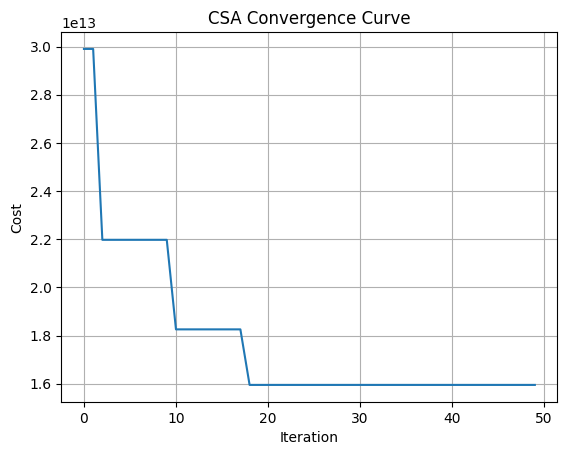

In [15]:
# CELL 10: CONVERGENCE

plt.plot(cost_history)
plt.title("CSA Convergence Curve")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()


In [16]:
# 11: RESOURCE ALLOCATION DECISIONS

# Decode offloading decisions
def decode_offload(o):
    if o == -1:
        return "Fog"
    elif o == 0:
        return "Local"
    else:
        return "Cloud"

allocation = [decode_offload(x) for x in best_o]

# Build decision table
allocation_df = pd.DataFrame({
    "Task_ID": np.arange(len(best_o)),
    "Offloading_Decision": allocation
})

display(allocation_df.head(15))

print("\nAllocation counts:")
print(allocation_df["Offloading_Decision"].value_counts())


,Task_ID,Offloading_Decision
0,0,Local
1,1,Fog
2,2,Local
3,3,Cloud
4,4,Local
5,5,Cloud
6,6,Local
7,7,Cloud
8,8,Local
9,9,Local



Allocation counts:
Offloading_Decision
Cloud    2903
Local    2887
Fog      2845
Name: count, dtype: int64


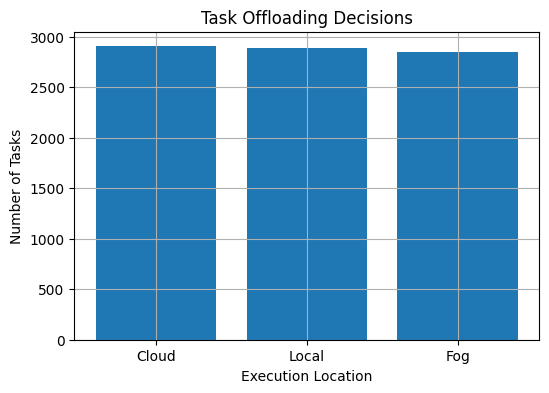

In [17]:
#12: OFFLOADING DISTRIBUTION PLOT

counts = allocation_df["Offloading_Decision"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values)
plt.title("Task Offloading Decisions")
plt.xlabel("Execution Location")
plt.ylabel("Number of Tasks")
plt.grid(True)
plt.show()


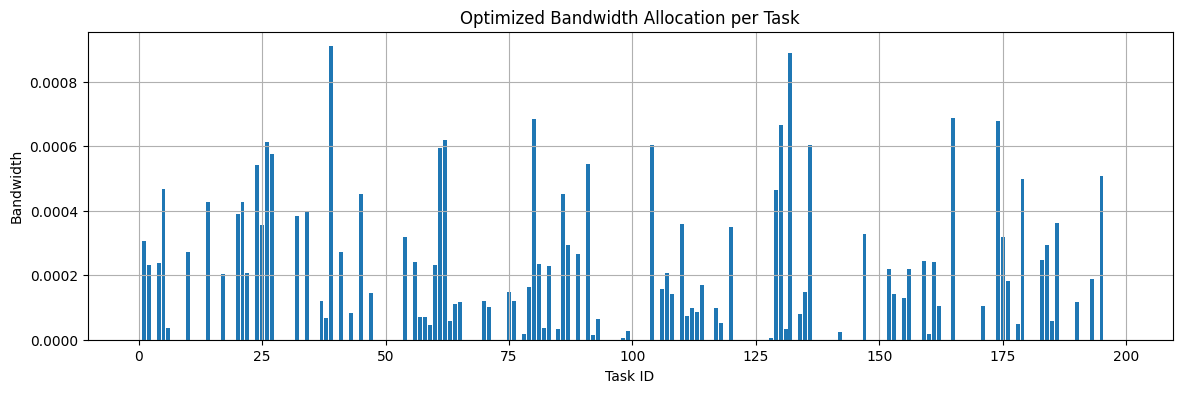

In [18]:
# FIGURE 1: Bandwidth per Task

plt.figure(figsize=(14,4))
plt.bar(np.arange(200), best_b[:200])
plt.title("Optimized Bandwidth Allocation per Task")
plt.xlabel("Task ID")
plt.ylabel("Bandwidth")
plt.grid(True)
plt.show()



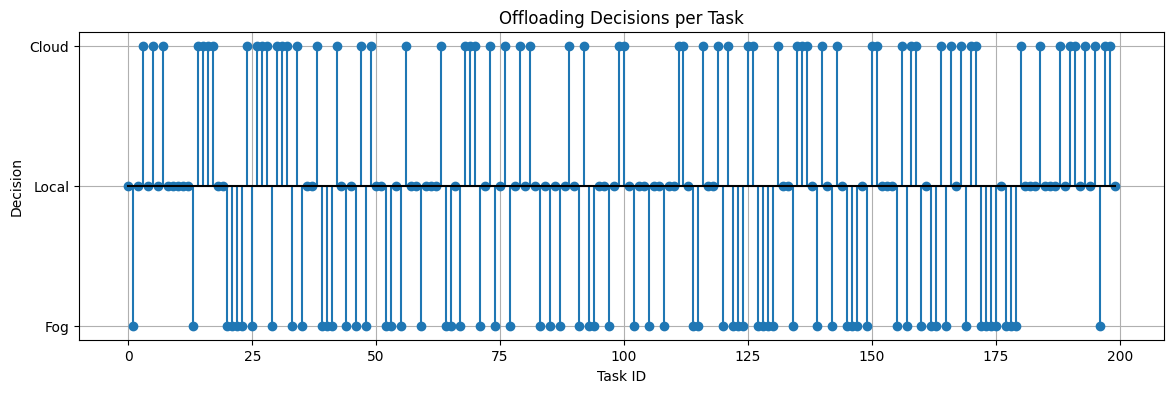

In [19]:
# FIGURE 2: Offloading Decisions per Task

plt.figure(figsize=(14,4))
plt.stem(np.arange(200), best_o[:200], basefmt="k")
plt.yticks([-1,0,1], ["Fog", "Local", "Cloud"])
plt.title("Offloading Decisions per Task")
plt.xlabel("Task ID")
plt.ylabel("Decision")
plt.grid(True)
plt.show()


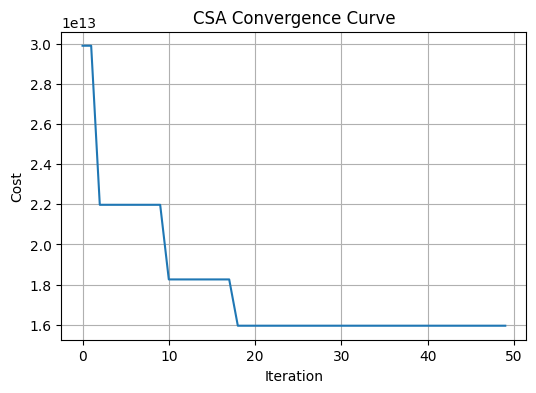

In [20]:
#csa convergence
plt.figure(figsize=(6,4))
plt.plot(cost_history)
plt.title("CSA Convergence Curve")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()


In [21]:
#  SUMMARY

summary = pd.DataFrame({
    "Metric": ["MSE", "Accuracy", "F1-score", "Final Cost"],
    "Value": [mse, accuracy, f1, best_cost]
})

display(summary)


,Metric,Value
0,MSE,2.869537e-03
1,Accuracy,9.974522e-01
2,F1-score,9.987245e-01
3,Final Cost,1.595043e+13


from matplotlib import pyplot as plt
summary['Value'].plot(kind='hist', bins=20, title='Value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
summary.groupby('Metric').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Value']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Value'}, axis=1)
              .sort_values('Value', ascending=True))
  xs = counted['Value']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('Value', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Metric')):
  _plot_series(series, series_name, i)
  fig.legend(title='Metric', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Value')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
summary['Value'].plot(kind='line', figsize=(8, 4), title='Value')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary, x='Value', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

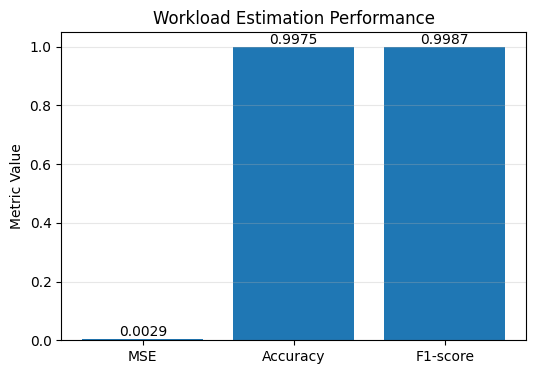

In [22]:
# Metrics
metrics_pred = ["MSE", "Accuracy", "F1-score"]
values_pred = [mse, accuracy, f1]

plt.figure(figsize=(6,4))
bars = plt.bar(metrics_pred, values_pred)

plt.title("Workload Estimation Performance")
plt.ylabel("Metric Value")
plt.grid(axis="y", alpha=0.3)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f"{height:.4f}", ha="center", va="bottom")

plt.show()


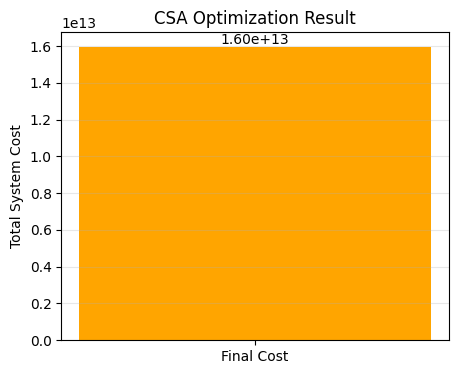

In [23]:
plt.figure(figsize=(5,4))
plt.bar(["Final Cost"], [best_cost], color="orange")

plt.title("CSA Optimization Result")
plt.ylabel("Total System Cost")
plt.grid(axis="y", alpha=0.3)

plt.text(0, best_cost, f"{best_cost:.2e}", ha="center", va="bottom")

plt.show()
